In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential, load_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from PIL import Image
import gradio as gr

In [2]:
tf.__version__

'2.16.1'

## Data Preparation

In [3]:
data     = []
labels   = []
classes  = 43 
cur_path = os.getcwd() + '/Dataset'
for i in range(classes): 
    path   = os.path.join(cur_path,'Train', str(i))
    images = os.listdir(path) 
    for a in images: 
        try: 
            image = Image.open(path + '/'+ a) 
            image = image.resize((30,30)) 
            image = np.array(image) / 255.0 
            data.append(image) 
            labels.append(i) 
        except: 
            print("Error loading image") 
data   = np.array(data, dtype=np.float32)
labels = np.array(labels)

In [4]:
#Splitting training and testing dataset
train_data, val_data, train_data_labels, val_data_labels = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)


print("Training Data:")
print(f"   Shape of Training Data          : {train_data.shape}")
print(f"   Shape of Training Data Labels   : {train_data_labels.shape}")
print()
print("Validation Data:")
print(f"   Shape of Validation Data        : {val_data.shape}")
print(f"   Shape of Validation Data Labels : {val_data_labels.shape}")

Training Data:
   Shape of Training Data          : (31367, 30, 30, 3)
   Shape of Training Data Labels   : (31367,)

Validation Data:
   Shape of Validation Data        : (7842, 30, 30, 3)
   Shape of Validation Data Labels : (7842,)


In [5]:
train_label_onehot = to_categorical(train_data_labels, 43)
val_label_onehot   = to_categorical(val_data_labels, 43)

In [6]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    '''
    This function will plot images in the form of a grid with 4 rows and 4 columns 
    '''
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # Normalize image pixel values to range [0, 1] if not already normalized
        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

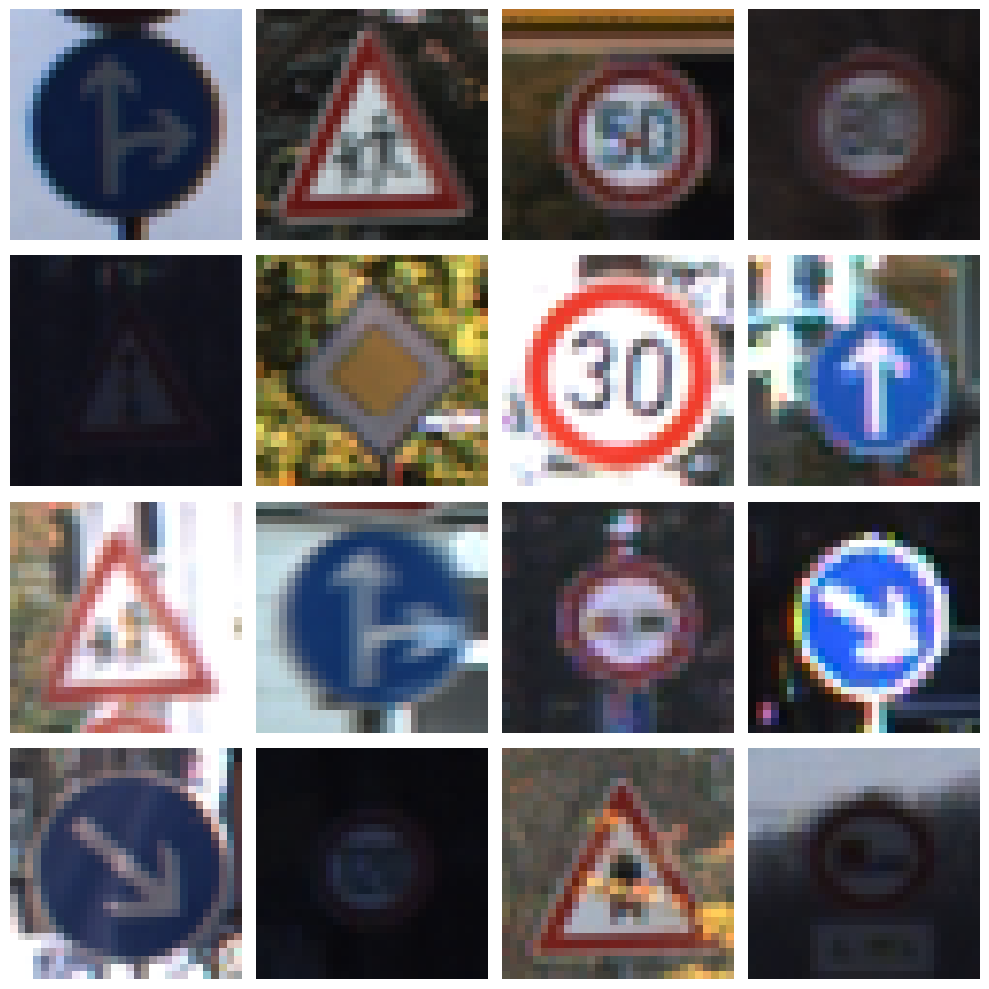

In [7]:
plotImages(train_data[:16])

In [8]:
#Building the model
model = Sequential()

# First Layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = train_data.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Layer 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))


# Dense Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model_checkpoint = ModelCheckpoint(filepath='primary_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping   = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max') #patience=5

history          = model.fit(train_data, train_label_onehot, epochs=30, batch_size = 64, callbacks=[model_checkpoint, early_stopping], 
                   validation_data=(val_data,val_label_onehot)) 

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.2926 - loss: 2.6061 - val_accuracy: 0.9273 - val_loss: 0.2670
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.8732 - loss: 0.4120 - val_accuracy: 0.9749 - val_loss: 0.0983
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9337 - loss: 0.2115 - val_accuracy: 0.9843 - val_loss: 0.0610
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 51s 104ms/step - accuracy: 0.9531 - loss: 0.1501 - val_accuracy: 0.9875 - val_loss: 0.0474
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.9654 - loss: 0.1132 - val_accuracy: 0.9907 - val_loss: 0.0406
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.9709 - loss: 0.0943 - val_accuracy: 0.9921 - val_loss: 0.0323
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.9723 - loss: 0.0883 - val_accuracy: 0.9921 - val_loss: 0.0338
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step - accuracy: 0.9789 - loss: 0

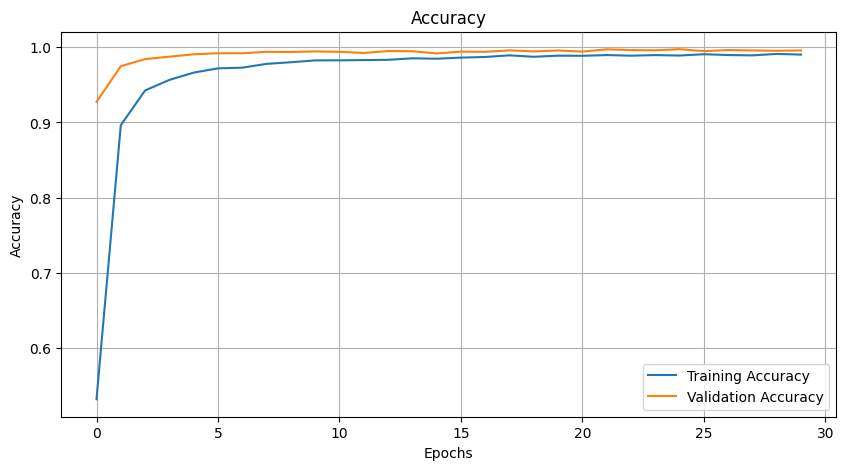

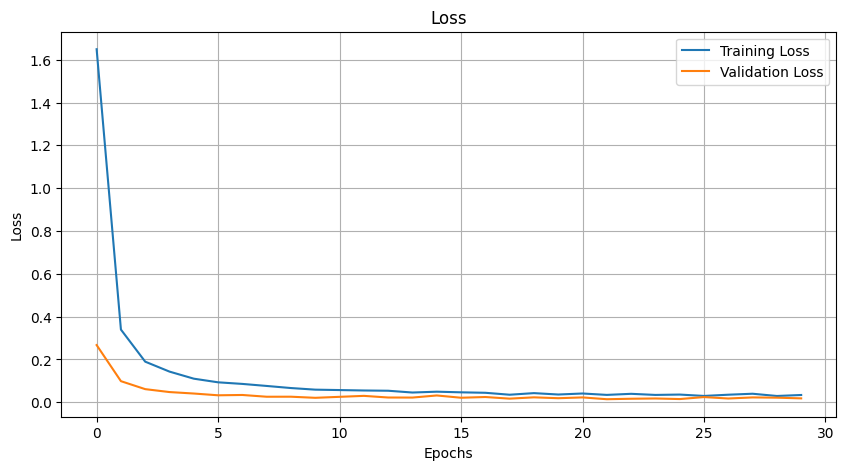

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
test_file = pd.read_csv('Dataset/Test.csv')
labels    = test_file["ClassId"].values
imgs      = test_file["Path"].values
imgs_list =  []
for img in imgs:
    image = Image.open('Dataset' + '/' + img)
    image = image.resize((30,30))
    imgs_list.append(np.array(image))
    
test_data    = np.array(imgs_list, dtype=np.float32)
pred         = model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)

#Accuracy with the test data
print(accuracy_score(labels, pred_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
0.9643705463182898
